In [25]:
import pandas as pd
import os
import matplotlib.pyplot as plt

In [19]:
RESULTS_PATH = os.path.join("benchmark", "results", "results.csv")

In [62]:
df = pd.read_csv(RESULTS_PATH)

In [63]:
df['version'].values

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [64]:
# TEST min_sim_db
versions = [6, 7, 8, 9, 10, 11, 12, 13, 14]
df_min_sim_db = df[df['version'].isin(versions)]
df_min_sim_db.sort_values('min_sim_db', inplace=True)

C:\Users\rdiaz\AppData\Local\Temp\ipykernel_12100\3839725963.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_min_sim_db.sort_values('min_sim_db', inplace=True)


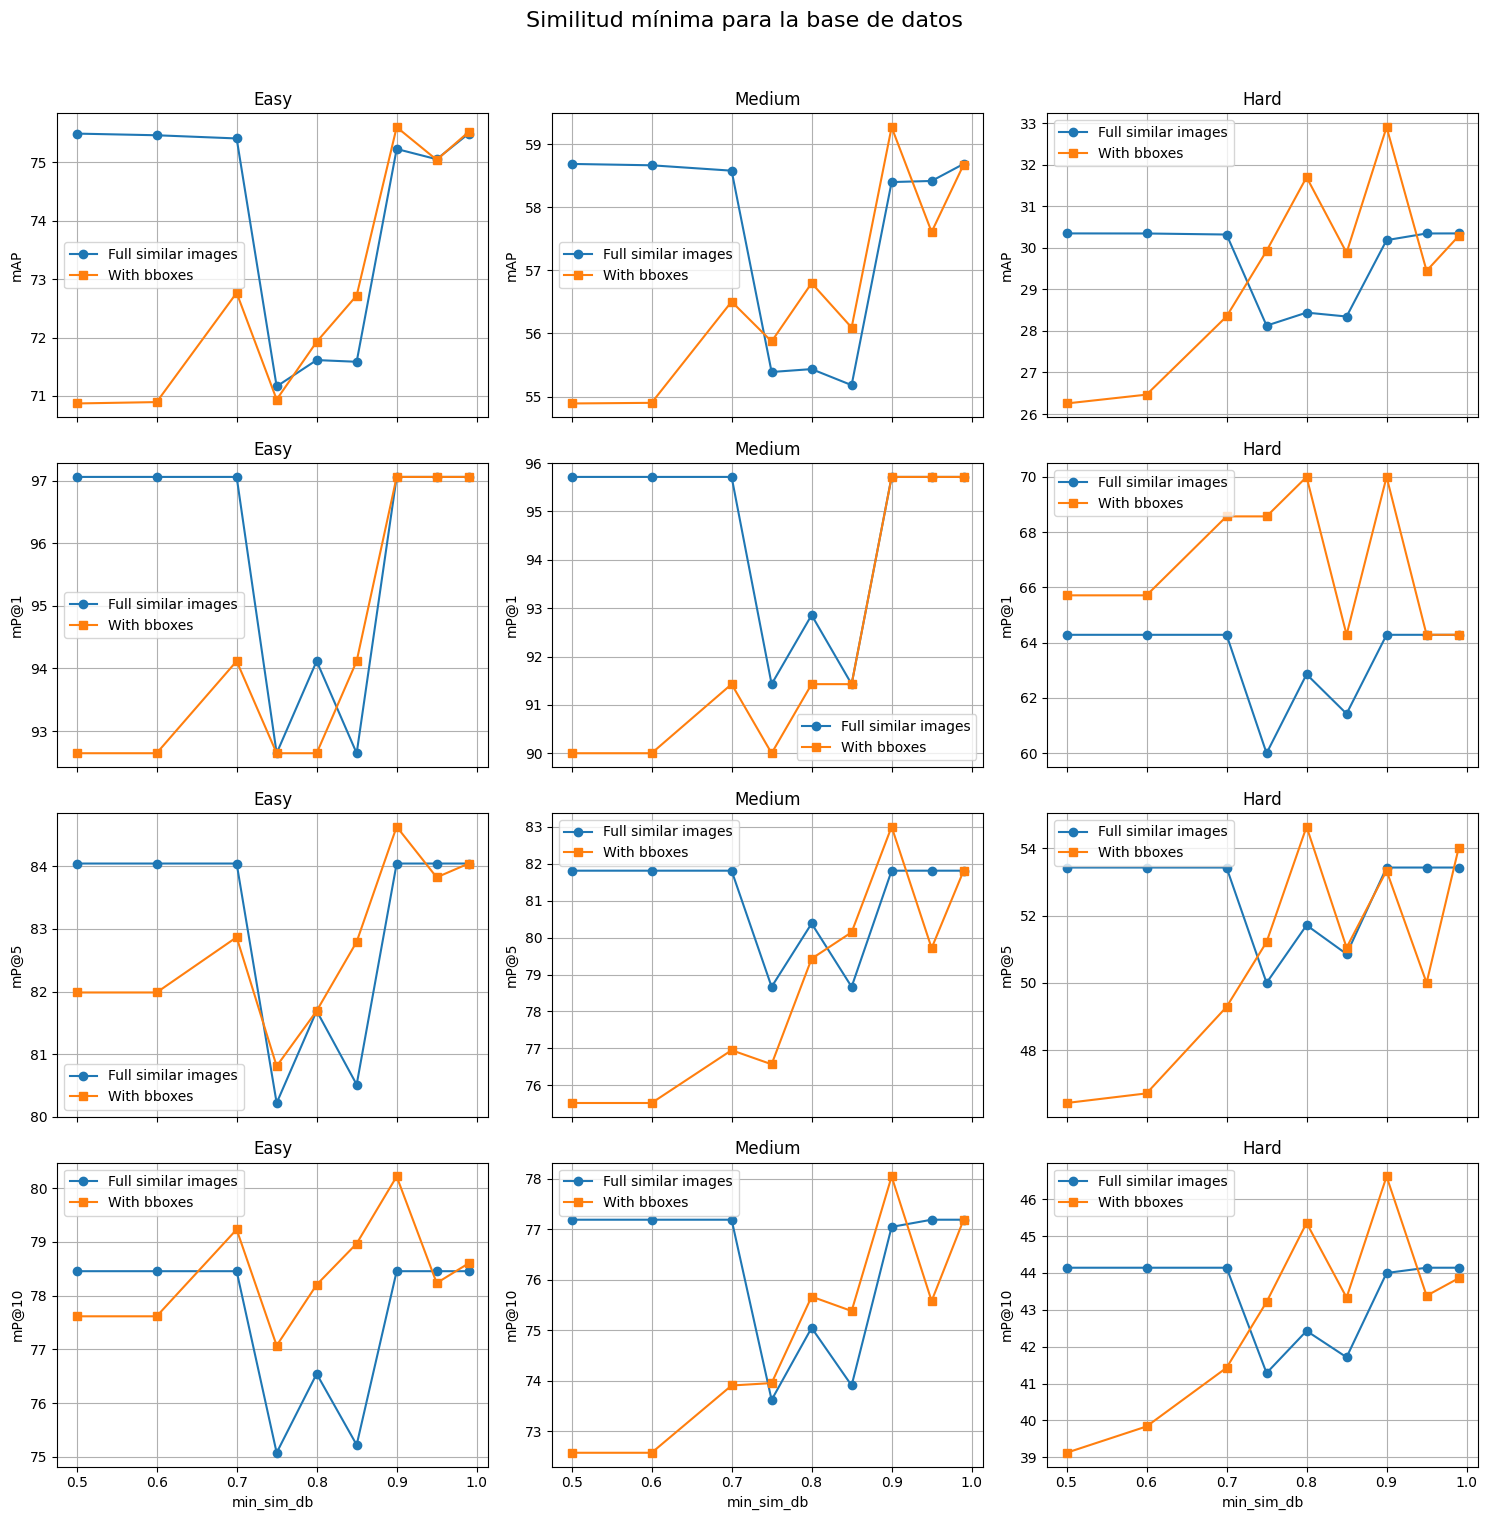

In [65]:
# Definir configuración de las métricas por nivel de dificultad
metrics = [
    ('map_easy', 'map_easy_bbox', 'Easy'),
    ('map_medium', 'map_medium_bbox', 'Medium'),
    ('map_hard', 'map_hard_bbox', 'Hard'),
    ('mp@1_easy', 'mp@1_easy_bbox', 'Easy'),
    ('mp@1_medium', 'mp@1_medium_bbox', 'Medium'),
    ('mp@1_hard', 'mp@1_hard_bbox', 'Hard'),
    ('mp@5_easy', 'mp@5_easy_bbox', 'Easy'),
    ('mp@5_medium', 'mp@5_medium_bbox', 'Medium'),
    ('mp@5_hard', 'mp@5_hard_bbox', 'Hard'),
    ('mp@10_easy', 'mp@10_easy_bbox', 'Easy'),
    ('mp@10_medium', 'mp@10_medium_bbox', 'Medium'),
    ('mp@10_hard', 'mp@10_hard_bbox', 'Hard')
]

# Crear subplots
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(15, 15), sharex=True, sharey=False)

for i, (ax, (col1, col2, title)) in enumerate(zip(axs.flat, metrics)):
    df_min_sim_db.plot(x='min_sim_db', y=col1, ax=ax, label='Full similar images', marker='o')
    df_min_sim_db.plot(x='min_sim_db', y=col2, ax=ax, label='With bboxes', marker='s')
    ax.set_title(title)
    ax.set_xlabel('min_sim_db')
    if i < 3:  # Primera fila (índices 0 a 2)
        ax.set_ylabel('mAP')
    elif i < 6:
        ax.set_ylabel('mP@1')
    elif i < 9:
        ax.set_ylabel('mP@5')
    else:      # Segunda fila (índices 3 a 5)
        ax.set_ylabel('mP@10')
    ax.grid(True)
    ax.legend()

plt.suptitle('Similitud mínima para la base de datos', fontsize=16, y=1.01)
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()